# Understanding The Problem


We would like to send $K$ layers of data in the form of OFDM symbols $\mathbf{s}_k\in \mathbb{C}^N$, of length $N$. This data is precoded into $N\geq K$ layers $\mathbf{x}_i\in\mathbb{C}^M$, to be sent out to $M$ antennas, ehich transmit to UEs via some wireless channels - $\mathbf{H}$.

Spatial constraint, i.e. UEs recieve what was initially sent to them:

\begin{equation}
\mathbf{Hx} = \mathbf{s}, \; \mathbf{s} = (\mathbf{s}_1^T, \dots, \mathbf{s}_K^T)^T.
\end{equation}

But realistically there may be noise/errors in the recieved symbols, quantified by EVM:

$$
\text{EVM} = \frac{\left\Vert\mathbf{Hx - s}\right\Vert_2}{\left\Vert\mathbf{s}\right\Vert_2}.
$$

Then, we also want to minimise PAPR, i.e essentially:
$$
\min_\mathbf{x}{\frac{\left\Vert\mathbf{F}^H\mathbf{x}\right\Vert_\infty^2}{\left\Vert\mathbf{x}\right\Vert_2^2}},
$$

keeping the spatial constraint in mind, as well.



In [98]:
import numpy as np
import matplotlib.pyplot as plt

In [61]:
subcarry_num = 64 # number of OFDM subcarriers
CP = subcarry_num//4  # 4th of each block length

# not sure if 'pilots' are relevant
P = 8 # pilot carriers per OFDM block
pilot_val = 3+3j # (arbitrary?) known value each pilot transmits

If 'pilots' are relevant then they should appear periodically within the carriers

all carriers:   [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
pilot carriers: [ 0  8 16 24 32 40 48 56 63]
data carriers:  [ 1  2  3  4  5  6  7  9 10 11 12 13 14 15 17 18 19 20 21 22 23 25 26 27
 28 29 30 31 33 34 35 36 37 38 39 41 42 43 44 45 46 47 49 50 51 52 53 54
 55 57 58 59 60 61 62]


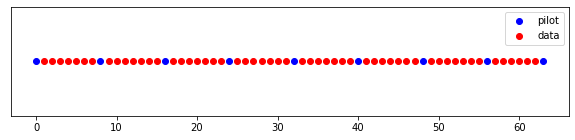

In [62]:
carry_indxs = np.arange(subcarry_num)  # indices of subcarriers 0, 1, ... subcarry_num-1

pilot_indxs = carry_indxs[::subcarry_num//P]

# For convenience let the last carrier also be a pilot
pilot_indxs = np.hstack([pilot_indxs, np.array([carry_indxs[-1]])])
P = P+1

# data carriers are the remaining carriers
data_indxs = np.delete(carry_indxs, pilot_indxs)

print ("all carriers:   %s" % carry_indxs)
print ("pilot carriers: %s" % pilot_indxs)
print ("data carriers:  %s" % data_indxs)

plt.figure(figsize=(10, 2))
plt.plot(pilot_indxs, np.zeros_like(pilot_indxs), 'bo', label='pilot')
plt.plot(data_indxs, np.zeros_like(data_indxs), 'ro', label='data')
plt.yticks([])
plt.legend()
plt.show()

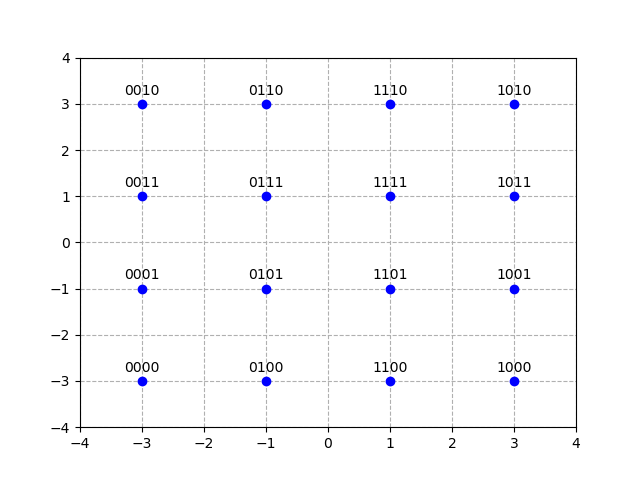

In [63]:
mu = 4 # bits per symbol (16QAM)
data_bits_per_OFDM = len(data_indxs)*mu  # number of payload bits per OFDM symbol

mapping_table = {
    (0,0,0,0) : -3-3j,
    (0,0,0,1) : -3-1j,
    (0,0,1,0) : -3+3j,
    (0,0,1,1) : -3+1j,
    (0,1,0,0) : -1-3j,
    (0,1,0,1) : -1-1j,
    (0,1,1,0) : -1+3j,
    (0,1,1,1) : -1+1j,
    (1,0,0,0) :  3-3j,
    (1,0,0,1) :  3-1j,
    (1,0,1,0) :  3+3j,
    (1,0,1,1) :  3+1j,
    (1,1,0,0) :  1-3j,
    (1,1,0,1) :  1-1j,
    (1,1,1,0) :  1+3j,
    (1,1,1,1) :  1+1j
}

%matplotlib widget
for b3 in [0, 1]:
    for b2 in [0, 1]:
        for b1 in [0, 1]:
            for b0 in [0, 1]:
                B = (b3, b2, b1, b0)
                Q = mapping_table[B]
                plt.plot(Q.real, Q.imag, 'bo')
                plt.text(Q.real, Q.imag+0.2, "".join(str(x) for x in B), ha='center')
                
plt.grid('True', linestyle='--')
plt.xlim((-4,4))
plt.ylim((-4,4))
plt.show()


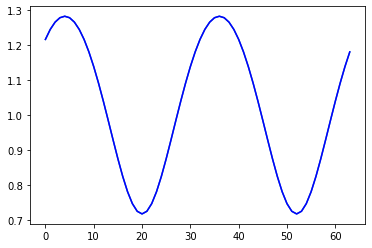

In [65]:
plt.close()
%matplotlib inline

demapping_table = {v : k for k, v in mapping_table.items()}

channel_resp = np.array([1, 0, 0.2+0.2j])  # the impulse response of the wireless channel
H_exact = np.fft.fft(channel_resp, subcarry_num)
plt.plot(carry_indxs, abs(H_exact))

SNRdb = 25  # signal to noise-ratio in dB at the receiver

plt.plot(carry_indxs, np.abs(H_exact), 'b')
plt.show()

In [66]:
bits = np.random.binomial(n=1, p=0.5, size=(data_bits_per_OFDM, ))
print ("Bits count: ", len(bits))
print ("First 20 bits: ", bits[:20])
print ("Mean: ", np.mean(bits))

Bits count:  220
First 20 bits:  [1 0 0 0 0 1 1 0 1 1 0 0 0 1 0 1 1 1 0 0]
Mean:  0.5272727272727272


In [67]:
def SP(bits):
    return bits.reshape((len(data_indxs), mu))

bits_SP = SP(bits)
print ("First 5 bit groups")
print (bits_SP[:5,:])

First 5 bit groups
[[1 0 0 0]
 [0 1 1 0]
 [1 1 0 0]
 [0 1 0 1]
 [1 1 0 0]]


In [69]:
def Mapping(bits):
    return np.array([mapping_table[tuple(b)] for b in bits])

QAM = Mapping(bits_SP)
print ("First 5 QAM symbols and bits:")
print (bits_SP[:5,:])
print( '-->')
print (QAM[:5])

First 5 QAM symbols and bits:
[[1 0 0 0]
 [0 1 1 0]
 [1 1 0 0]
 [0 1 0 1]
 [1 1 0 0]]
-->
[ 3.-3.j -1.+3.j  1.-3.j -1.-1.j  1.-3.j]


In [70]:
def OFDM_symbol(data_as_QAM):
    symbol = np.zeros(subcarry_num, dtype=complex) 
    symbol[pilot_indxs] = pilot_val  # allocate the pilot subcarriers 
    symbol[data_indxs] = data_as_QAM  # allocate the pilot subcarriers
    return symbol

OFDM_data = OFDM_symbol(QAM)
print ("Number of OFDM carriers in frequency domain: ", len(OFDM_data))
print("First 5 entries:", OFDM_data[:5])

Number of OFDM carriers in frequency domain:  64
First 5 entries: [ 3.+3.j  3.-3.j -1.+3.j  1.-3.j -1.-1.j]


[ 0.28125   +0.46875j     0.20870866-0.41104449j  0.22743707-0.17230935j
  0.26897748+0.02941509j -0.01638944+0.18882752j]
Number of OFDM samples in time-domain before CP:  64


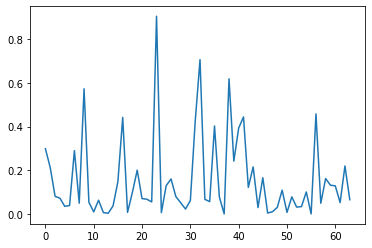

PAPR: 5.780188880148057


In [71]:
def IDFT(OFDM_data_in):
    return np.fft.ifft(OFDM_data_in)

OFDM_time = IDFT(OFDM_data)
print(OFDM_time[:5])
print ("Number of OFDM samples in time-domain before CP: ", len(OFDM_time))

plt.plot(carry_indxs, np.abs(OFDM_time)**2)
plt.show()
print("PAPR:", np.max(np.abs(OFDM_time)**2) / np.mean(np.abs(OFDM_time)**2))

In [72]:
def addCP(OFDM_time):
    cp = OFDM_time[-CP:]               # take the last CP samples 
    return np.hstack([cp, OFDM_time])  # add them to the beginning

OFDM_withCP = addCP(OFDM_time)
print ("Number of OFDM samples in time domain with CP: ", len(OFDM_withCP))


Number of OFDM samples in time domain with CP:  80


RX Signal power: 0.1573. Noise power: 0.0005


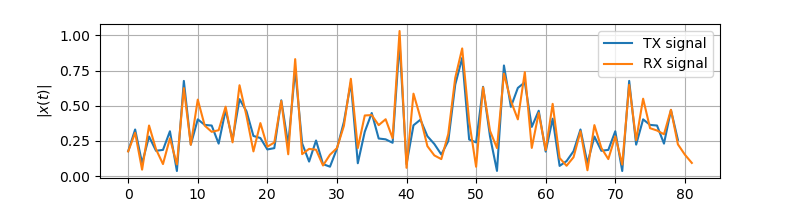

In [73]:
def channel(signal):
    convolved = np.convolve(signal, channel_resp)
    signal_power = np.mean(abs(convolved**2))
    sigma2 = signal_power * 10**(-SNRdb/10)  # simulate noise
    
    print ("RX Signal power: %.4f. Noise power: %.4f" % (signal_power, sigma2))
    
    # Generate complex noise with given variance
    noise = np.sqrt(sigma2/2) * (np.random.randn(*convolved.shape)+1j*np.random.randn(*convolved.shape))
    return convolved + noise


OFDM_TX = OFDM_withCP
OFDM_RX = channel(OFDM_TX)
%matplotlib widget
plt.figure(figsize=(8,2))
plt.plot(abs(OFDM_TX), label='TX signal')
plt.plot(abs(OFDM_RX), label='RX signal')
plt.legend(fontsize=10)
plt.xlabel('Time')
plt.ylabel('$|x(t)|$')
plt.grid(True)





# Random Tests Follow




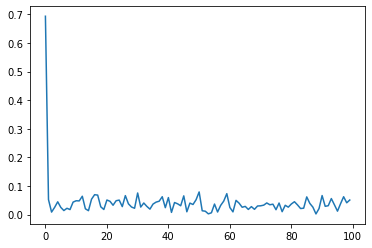

In [75]:
%matplotlib inline
a = np.random.rand(100)
b = np.random.rand(100)
arr = a + b*1j

trial = np.fft.ifft(arr)
plt.plot(np.abs(trial))
plt.show()

In [4]:
y = np.random.uniform(low=-2, high=2 ,size=100)
print(y[:5])

[-1.517083    1.41083767 -0.9377762  -1.36963721  1.53376563]


In [7]:
y = np.random.rand(100)
print(y[:5])
print(np.max(y), np.min(-y))

[0.52836311 0.72759387 0.32817945 0.67246526 0.69700997]
0.9793630858413428 -0.9793630858413428


In [100]:
def Gaussian(x, amp, stdev, center):
    return amp*np.exp(- (x - center)**2 / (2*stdev**2))


[ 0.99120281+0.13235175j  0.4242714 +0.90553508j -0.51528037+0.85702167j
 -0.99752465+0.07031768j -0.64612195-0.76323419j]


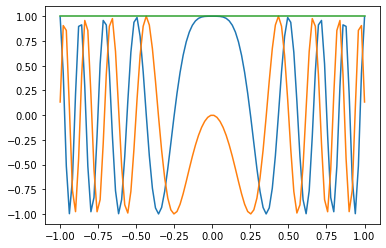

In [77]:
a = np.linspace(-1,1,100)
b = np.linspace(-1,1,100)
arr = a + b*1j

fun = Gaussian(arr, 1, 0.2, 0)
print(fun[:5])

plt.plot(arr.real, fun.real)
plt.plot(arr.imag,fun.imag)
plt.plot(arr.real, np.abs(fun))
plt.show()

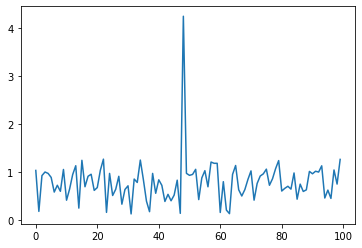

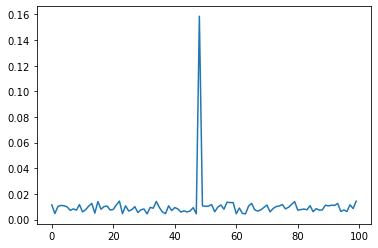

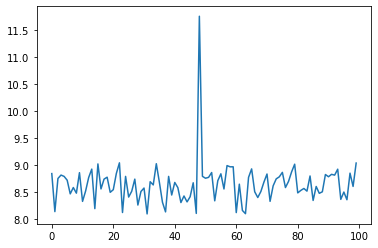

In [164]:
a = np.random.rand(100)
b = np.random.rand(100)
arr = a + b*1j

maximum = np.random.randint(0,100)
arr[maximum] = 3+3*1J

plt.plot(np.abs(arr))
plt.show()

def Cost(x,c,r):
    return (x+c)**2 / r


def Max_approx(x):
    return np.min(x)+np.min(-x)


plt.plot(Gaussian(np.abs(arr), 1, 3, 10))
plt.show()

plt.plot(Cost(np.abs(arr), 20, 50))
plt.show()


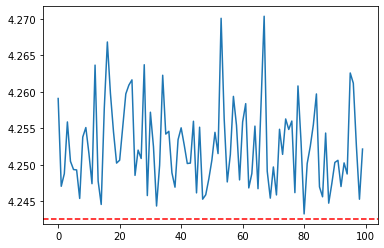

In [163]:
def Max_approx(x):
    return np.min(x)-np.min(-x)

approx = []
actual = []
for i in range(100):
    a = np.random.rand(100)
    b = np.random.rand(100)
    arr = a + b*1j

    maximum = np.random.randint(0,100)
    arr[maximum] = 3+3*1J
    
    approx.append(Max_approx(np.abs(arr)))
    actual.append(np.abs(arr[maximum]))
    

plt.plot(approx)
plt.axhline(y=actual[0], c='r', linestyle='--')
plt.show()


### EVM Constraint

This is a 2-norm, which has a well-known QUBO formulation:

\begin{align}
    \left\Vert\mathbf{Hx - s}\right\Vert_2^2\nonumber &= \sum_i^M \left(\sum_j^N H_{ij}x_j - s_i\right)^2\nonumber\\
    &= \sum_i^M \left(\left(\sum_j^N H_{ij}x_j\right)^2 - 2s_i\sum_j^N H_{ij}x_j + s_i^2\right)\nonumber\\
    &= \sum_i^M \left(\sum_j^N (H_{ij}x_j)^2 +2\sum_{i<k}H_{ij}H_{ik}x_ix_k - 2s_i\sum_j^N H_{ij}x_j + s_i^2\right)
\end{align}
But as $x_i$ are continuous variables we need to transform them into their binary representation, i.e. in terms of some $q_i\in\{0,1\}$. To obtain the full QUBO, we therefore need to

1. Bind $x_i$ to a domain $D_i\subset \mathbb{C}$
2. Expand in some binary represenation, $x_i = \pm\sum_n a_np^n$.

Once we do that, we should arrive at some $g(\mathbf{x})$, the fully QUBO ready function.



### Max-norm

We would either like to minimize or constrain the max-norm $\Vert \mathbf{y} \Vert_\infty = \max\{\lvert y_1 \rvert, \dots, \lvert y_N \rvert\}$, where $\mathbf{y} = F^H\mathbf{x} $. We can either have 

\begin{align}
&\min_{\mathbf{x}}(\Vert F^H\mathbf{x} \Vert_\infty + \gamma_1 g(\mathbf{x}) ) &\text{or}& &\min_{\mathbf{x}}(g(\mathbf{x}) + \gamma_2 \Vert F^H\mathbf{x} \Vert_\infty)
\end{align}

The max-norm as a constraint just means that we need to penalise for values above certain threshold $a$. So we could  minimize the $l_2$-norm $g(\mathbf{x})$ subject to $\lvert y_i\rvert \leq a, \forall i$. The first case, we could write as

<!-- \begin{align}
    &\min_{\mathbf{x}}(t + \gamma_1 g(\mathbf{x}) )\\
    &\text{s.t. }\;\; \left\lvert\left(\sum_j^N (\mathbf{F}^H)_{ij}x_j\right)\right\rvert \leq t, \;\forall i=1,\dots, M,\\
    &\text{or }\;\; -t\mathbf{1} \leq \mathbf{F}^H\mathbf{x} \leq t\mathbf{1},
\end{align} -->

In [175]:
import scipy as sc
from scipy import linalg

from numpy import ndarray

# class myarray(ndarray):    
#     @property
#     def H(self):
#         return self.conj().T

W = np.array(sc.linalg.dft(2))
print(W, '\n')

print(np.linalg.inv(W), '\n')

print(W.conj().T, '\n')

a = np.array([[1,1],[1,-1]])

print(a.conj().T, '\n')
print(np.linalg.inv(a), '\n')
print(W == a)

[[ 1.+0.0000000e+00j  1.+0.0000000e+00j]
 [ 1.+0.0000000e+00j -1.-1.2246468e-16j]] 

[[ 0.5+3.061617e-17j  0.5-3.061617e-17j]
 [ 0.5-3.061617e-17j -0.5+3.061617e-17j]] 

[[ 1.-0.0000000e+00j  1.-0.0000000e+00j]
 [ 1.-0.0000000e+00j -1.+1.2246468e-16j]] 

[[ 1  1]
 [ 1 -1]] 

[[ 0.5  0.5]
 [ 0.5 -0.5]] 

[[ True  True]
 [ True False]]


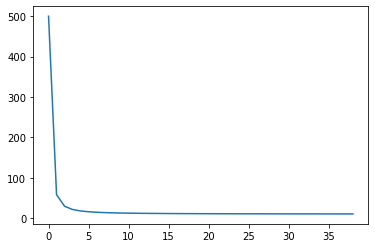

In [438]:
def Lpnorm(x,p):
    p = int(p)
    elementsum = np.sum(np.abs(x)**p)
    return np.power(elementsum, 1/p)

x = np.linspace(0,10,100)

out = np.empty(39)

for i in range(39):
    out[i] = Lpnorm(x,i+1)
plt.plot(out)
plt.show()

[0.76260331 0.03803311 0.04452244 0.04137643 0.03581288 0.03204674
 0.06725389 0.09400447 0.02338829 0.00586257 0.03848402 0.10079221
 0.02086318 0.04400263 0.05254281 0.05794218 0.0941403  0.05183397
 0.07303495 0.03055203 0.02462315 0.01398682 0.05388524 0.03302322
 0.01850389 0.04025531 0.04839197 0.07773487 0.03510996 0.03885423
 0.03775154 0.04899056 0.04417086 0.0278825  0.05867324 0.01022381
 0.04992711 0.03727767 0.07328817 0.0129502  0.07584417 0.03558012
 0.04674295 0.00663075 0.01658488 0.04452733 0.04043958 0.10092775
 0.00391211 0.06601625 0.0505869  0.03824782 0.01976049 0.03835953
 0.06510565 0.02881995 0.09053017 0.01190378 0.06865917 0.05986827
 0.0131139  0.01831094 0.09179653 0.06745468] 



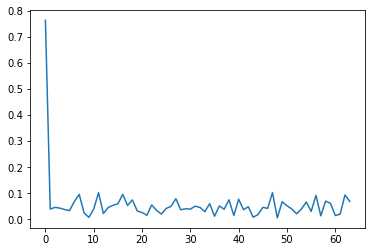

In [254]:
a = np.random.rand(64)
b = np.random.rand(64)

xvec = a + b*1J  # precoded vector

# print(xvec, '\n')

# dft_mat = np.array(sc.linalg.dft(64))
# inv_dft = np.linalg.inv(dft_mat)

xvec_time = np.fft.ifft(xvec)



print(np.abs(xvec_time), '\n')
plt.plot(np.abs(xvec_time))
plt.show()

# print(Lpnorm(vec,10), np.mean(np.abs(vec)), np.max(np.abs(vec)))

16
[ 8  7  4  4 10 13  8  3  1  2  7  3  4  4  9 13]
[ 3.-3.j -1.+1.j -1.-3.j -1.-3.j  3.+3.j  1.-1.j  3.-3.j -3.+1.j -3.-1.j
 -3.+3.j -1.+1.j -3.+1.j -1.-3.j -1.-3.j  3.-1.j  1.-1.j]
[0.79056942 0.74338603 0.83238312 1.13796188 0.35355339 0.51978479
 0.49009857 0.27078647 1.11803399 0.30113623 0.93254402 0.97565464
 0.         0.67935112 0.97329512 1.2469224 ]


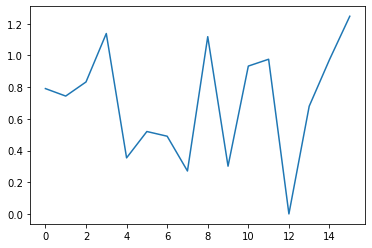

In [283]:
samples = np.array(list(mapping_table.values()))

n=len(samples)

print(n)

index = np.random.randint(n-1,size=n)
print(index)

# let this be the precoded (althought its more like s)
x = samples[index]
print(x)

xtime = np.fft.ifft(x)
print(np.abs(xtime))

plt.plot(np.abs(xtime))
plt.show()

[ 60  97 150 166 190 210 233 239 374 385 435 460 516 580 655 727 739 764
 765 768 812 822 954 966] 

[12.17423696 12.08499604 12.10273234 13.19090186 12.29278668 12.88588848
 12.16136692 15.76670193 13.15194771 13.96857299 12.34882037 12.36656024
 13.63622763 12.08378635 12.41300623 13.29782035 13.90095097 13.79844214
 12.04758714 13.4204337  14.36513015 14.12776693 14.11176296 13.89649285] 

[[77. 57. 50. 72.]
 [70. 58. 66. 62.]
 [65. 76. 64. 51.]
 [67. 65. 62. 62.]
 [59. 74. 67. 56.]
 [53. 62. 73. 68.]
 [75. 53. 70. 58.]
 [57. 64. 66. 69.]
 [60. 60. 67. 69.]
 [66. 59. 69. 62.]
 [78. 66. 59. 53.]
 [68. 55. 62. 71.]
 [57. 58. 79. 62.]
 [60. 70. 63. 63.]
 [68. 58. 62. 68.]
 [70. 66. 57. 63.]
 [60. 63. 65. 68.]
 [68. 73. 51. 64.]
 [61. 68. 59. 68.]
 [69. 62. 59. 66.]
 [63. 66. 61. 66.]
 [75. 64. 58. 59.]
 [81. 51. 56. 68.]
 [66. 71. 57. 62.]] 

[77. 70. 76. 67. 74. 73. 75. 69. 69. 69. 78. 71. 79. 70. 68. 70. 68. 73.
 68. 69. 66. 75. 81. 71.]


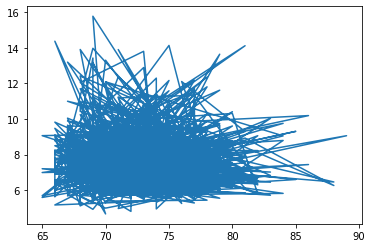

In [433]:
samples = np.array([1+1J, -1+1J, -1-1J, 1-1J])

n = 256 #size of random s array

arr = np.empty(n, dtype=complex)

num = 1000

occur_history = np.zeros((num,len(samples)))

papr_history = np.zeros(num)

for j in range(num):
    randpick = np.random.randint(0,len(samples), size=n)

    occur_history[j] = np.bincount(randpick)

    # a random data input
    for i in range(n):
        arr[i] = samples[randpick[i]]


    arr_time = np.fft.ifft(arr)

    papr_history[j] = np.max(np.abs(arr_time))**2 / np.mean(np.abs(arr_time))**2 

indx = np.where(papr_history > 12)[0]
print(indx, '\n')
print(papr_history[indx], '\n')

print(occur_history[indx], '\n')

print(np.max(occur_history[indx], axis=1))

plt.plot(np.max(occur_history, axis=1), papr_history)
plt.show()

In [448]:
# constellation points in 16QAM
samples = np.array(list(mapping_table.values()))

print(samples, '\n')

# print(np.angle(samples), '\n')

# print(np.sort(np.angle(samples)))

n = 256 #size of random s array

arr = np.empty(n, dtype=complex)

num = 1000

# occur_history = np.zeros((num,len(samples)))

# papr_history = np.zeros(num)

# for j in range(num):
#     randpick = np.random.randint(0,len(samples), size=n)

#     occur_history[j] = np.bincount(randpick)

#     # a random data input
#     for i in range(n):
#         arr[i] = samples[randpick[i]]


#     arr_time = np.fft.ifft(arr)

#     papr_history[j] = np.max(np.abs(arr_time))**2 / np.mean(np.abs(arr_time))**2 

# indx = np.where(papr_history > 12)[0]
# print(indx, '\n')
# print(papr_history[indx], '\n')

# print(occur_history[indx], '\n')

# print(np.max(occur_history[indx], axis=1))

[-3.-3.j -3.-1.j -3.+3.j -3.+1.j -1.-3.j -1.-1.j -1.+3.j -1.+1.j  3.-3.j
  3.-1.j  3.+3.j  3.+1.j  1.-3.j  1.-1.j  1.+3.j  1.+1.j] 



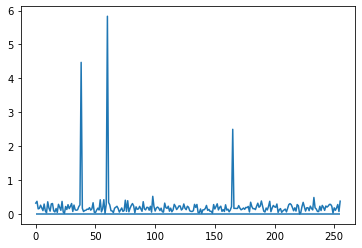

max =  5.830951894845301 

papr =  0.012499999999999999  =  -19.030899869919434 dB 

L_2(x) - max(time envelope) =  46.322667346775894 

L2norm of difference =  52.316754200546065 

5.99408685377017


In [566]:
randpick = np.random.randint(0,len(samples), size=n)

# a random data input
for i in range(n):
    arr[i] = samples[randpick[i]]


arrt = np.fft.ifft(arr)

maximum = np.random.randint(len(arrt), size = 3)
arrt[maximum] = [5+3J, 2+4J, 1.5+2J] 

envelope = np.abs(arrt)

enorm = Lpnorm(arr, 2)

papr = ( np.max(envelope) / enorm )**2

plt.plot(envelope)
plt.hlines(y=papr, xmin=0,xmax=len(envelope)-1)
plt.show()

print('max = ', np.max(envelope), '\n')



print('papr = ', papr, ' = ', 10*np.log10(papr), 'dB', '\n')

difference = (enorm - np.max(envelope))

print('L_2(x) - max(time envelope) = ', difference, '\n')

both2norm = Lpnorm(arrt-arr, 2)

print('L2norm of difference = ', both2norm, '\n')

dev = both2norm - difference

print(dev)

In [480]:
x = np.array([1+1J, 3+3J])
xt = np.fft.ifft(x)

print(xt)

xtm = (1/np.sqrt(2)) * np.array([[1,1],[1,-1]]) @ x

print(xtm)

[ 2.+2.j -1.-1.j]
[ 2.82842712+2.82842712j -1.41421356-1.41421356j]


In [561]:
n=7


W = 1/np.sqrt(n)*np.array(sc.linalg.dft(n))
# print('dft = ', np.around(W,decimals=1),'\n')
# print('transp conj = ', np.around(W.conj().T,decimals=1),'\n')

W = (1/np.sqrt(n))*np.array(sc.linalg.dft(n))
W = np.linalg.inv(W)

# print('inv = ', np.around(W,decimals=2), '\n')

print('square inv', np.around(W@W,decimals=2), '\n')

nonzero = np.transpose(np.nonzero(np.around(W@W,decimals=2)))
print(nonzero)


look = np.zeros((n,n))
for i in range(len(nonzero)):
    look[nonzero[i,0],nonzero[i,1]] = 1
print(look)

square inv [[ 1.-0.j  0.-0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.-0.j]
 [ 0.+0.j -0.+0.j -0.+0.j  0.+0.j  0.+0.j  1.-0.j -0.+0.j]
 [ 0.-0.j -0.+0.j -0.-0.j  0.+0.j  1.-0.j -0.-0.j -0.+0.j]
 [ 0.-0.j  0.-0.j  0.+0.j  1.-0.j -0.+0.j -0.+0.j  0.+0.j]
 [ 0.-0.j -0.+0.j  1.-0.j -0.+0.j -0.+0.j  0.+0.j  0.-0.j]
 [ 0.+0.j  1.-0.j -0.+0.j -0.+0.j -0.+0.j  0.+0.j  0.+0.j]] 

[[0 0]
 [1 6]
 [2 5]
 [3 4]
 [4 3]
 [5 2]
 [6 1]]
[[1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]]


2
12
30
56


In [595]:
def Channel_Rayleigh(no_users, no_transmit, rayleigh_scale=None):
    """Returns a random, complex Rayleigh fading wireles channel 
    matrix of size (no_users, no_transmit)
    
    TODO: include seed option, to return same matrix for testing."""
    
    if rayleigh_scale is None:
        rayleigh_scale = 1
    else:
        None
    
    re_H = np.random.rayleigh(rayleigh_scale, (no_users, no_transmit))
    im_H = np.random.rayleigh(rayleigh_scale, (no_users, no_transmit))
    
    H = re_H + im_H*1J
    
    return H


In [ ]:
def Precoder_Mat(channel_mat):
    """Given a wireless channel matrix, return zero-forcing precoder matrix"""
    
    

1.0 
 0.4999999999999999 
 0.4999999999999999 



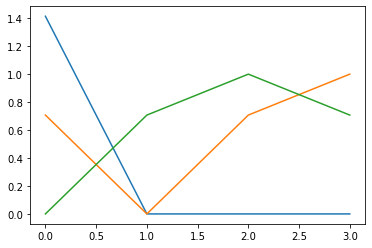

In [589]:
s1 = np.array([1+1J, 1+1J,1+1J, 1+1J])
s2 = np.array([1+1J, 1+1J,-1+1J, 1-1J])
s3 = np.array([1+1J, -1-1J,-1+1J, 1-1J])

s1t = np.fft.ifft(s1)
s2t = np.fft.ifft(s2)
s3t = np.fft.ifft(s3)

envelope1 = np.abs(s1t)
envelope2 = np.abs(s2t)
envelope3 = np.abs(s3t)

enorm1 = Lpnorm(s1t, 2)
enorm2 = Lpnorm(s2t, 2)
enorm3 = Lpnorm(s3t, 2)

papr1 = ( np.max(envelope1) / enorm1 )**2
papr2 = ( np.max(envelope2) / enorm2 )**2
papr3 = ( np.max(envelope3) / enorm3 )**2

print(papr1, '\n', papr2, '\n', papr3, '\n')

plt.plot(envelope1)
plt.plot(envelope2)
plt.plot(envelope3)
plt.show()

In [610]:
samples = np.array(list(mapping_table.values()))

n=len(samples)

print(n)

index = np.random.randint(n,size=6)
# print(index)

# let this be the precoded (althought its more like s)
x = samples[index]
print(x, '\n')

W = np.around(np.array(sc.linalg.dft(6)), decimals=2)

Wh = W.conj().T

xtime = np.fft.ifft(x)

print(Wh, '\n')

print(Wh @ x, '\n')
print(xtime, '\n')
print(np.abs(Wh @ x))

16
[ 1.-3.j -1.-1.j -1.-3.j -3.-1.j -3.+1.j -1.+3.j] 

[[ 1. -0.j    1. -0.j    1. -0.j    1. -0.j    1. -0.j    1. -0.j  ]
 [ 1. -0.j    0.5+0.87j -0.5+0.87j -1. +0.j   -0.5-0.87j  0.5-0.87j]
 [ 1. -0.j   -0.5+0.87j -0.5-0.87j  1. -0.j   -0.5+0.87j -0.5-0.87j]
 [ 1. -0.j   -1. +0.j    1. -0.j   -1. +0.j    1. -0.j   -1. +0.j  ]
 [ 1. -0.j   -0.5-0.87j -0.5+0.87j  1. -0.j   -0.5-0.87j -0.5+0.87j]
 [ 1. -0.j    0.5-0.87j -0.5-0.87j -1. +0.j   -0.5+0.87j  0.5+0.87j]] 

[-8.  -4.j   11.96+1.74j  1.  -5.74j  2.  -6.j    1.  -2.26j -1.96-1.74j] 

[-1.33333333-0.66666667j  1.98803387+0.28867513j  0.16666667-0.9553418j
  0.33333333-1.j          0.16666667-0.37799153j -0.32136721-0.28867513j] 

[ 8.94427191 12.08590915  5.8264569   6.32455532  2.4713559   2.62091587]
